# EDA

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns

C:\Users\pault\AppData\Local\Temp\ipykernel_19800\4098926419.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv("card_credit_fraud.csv", delimiter=";", decimal=",")
df_original = df.copy()
df.head()

,transactionId,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


Notre Dataframe ne s'affiche pas correctement lorsqu'on utilise `df.head()`. Après inspection de notre CSV, il semblerait que le problème soit les guillemets entourant chacune des lignes du CSV. Nous pouvons donc retirer ces guillemets et voir ce que cela donne :

## Avant
![image.png](src/trouver_guillemets.png)

## Après
![image2.png](src/csv_sans_guillemet.png)


Notre Dataframe devrait maintenant s'afficher correctement :


In [3]:
df = pd.read_csv("card_credit_fraud.csv", delimiter=";", decimal=",")
df.head()

,transactionId,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


# Observation du dataframe

**Taille** : 1008213 lignes par 11 colonnes.

**Présence de valeur null** : Aucune valeur null

**Description de nos features** : 

| Colonne          | Description                                                                                                                |
|------------------|----------------------------------------------------------------------------------------------------------------------------|
| transactionId    | Sert d'index                                                                                                               |
| step             | Heure à laquelle la transaction s'est passée. Minimum = 1 Maximum = 743 ; 743 / 24 ~= 31                                |
| type             | Le type de la transaction. Peut prendre plusieurs valeurs sous forme de chaînes de caractères.  |
| amount           | Le montant de chaque transaction                                                                                          |
| nameOrig         | Numéro de compte de l'émetteur. preprocessing`                                                                                            |
| oldbalanceOrg    | Solde de l'émetteur avant la transaction                                                                                   |
| newbalanceOrig    | Solde de l'émetteur après la transaction                                                                                   |
| nameDest         | Numéro de compte du destinataire.                                                                                           |
| oldbalanceDest   | Solde du destinataire avant la transaction                                                                                 |
| newbalanceDest   | Solde du destinataire après la transaction                                                                                 |
| isFraud          | Notre cible, non fraude = 0 ; fraude = 1                                                                                   |


In [4]:
print("Taille du df : ", df.shape)
print()
print("Présence de valeur nul:", df.isnull().any())
print()
print("Valeur maximum dans step :", df["step"].max())
print()


# On vérifie ici si notre dataset contient des datapoints ayant le même numéro de compte en receveur de TRANSFER et émetteur de CASH_OUT
fraud = df[df["isFraud"] == 1]
fraud_transfer = fraud[fraud["type"] == "TRANSFER"]
fraud_cashout = fraud[fraud["type"] == "CASH_OUT"]
print("Est-ce qu'il y a des lignes de notre df où le destinataire d'un transfer && l'émetteur d'un cash out ont le même numéro de compte ?", fraud_transfer.nameDest.isin(fraud_cashout.nameOrig).any())

# On enlève dès maintenant ces deux features
df = df.drop(["nameOrig", "nameDest"], axis=1) 

Taille du df :  (1008213, 11)

Présence de valeur nul: transactionId     False
step              False
type              False
amount            False
nameOrig          False
oldbalanceOrg     False
newbalanceOrig    False
nameDest          False
oldbalanceDest    False
newbalanceDest    False
isFraud           False
dtype: bool

Valeur maximum dans step : 743

Est-ce qu'il y a des lignes de notre df où le destinataire d'un transfer && l'émetteur d'un cash out ont le même numéro de compte ? False


## Encodage des valeurs nominales pour pouvoir réaliser une heatmap

In [5]:
df_pre_encoded = df.copy()
df = pd.concat([df,pd.get_dummies(df['type'], prefix='type_')],axis=1)
df.drop(['type'],axis=1,inplace = True)

## Corrélations entre les features

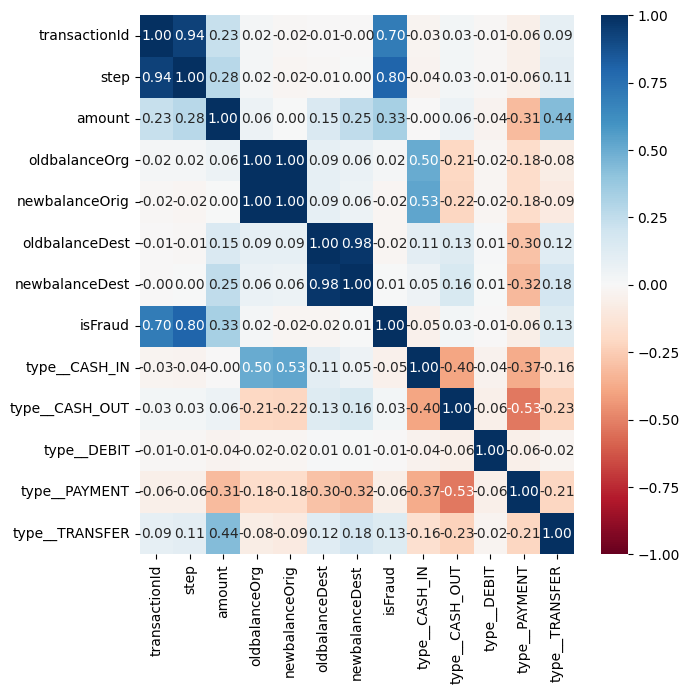

In [6]:
plt.figure(figsize=(7,7))
sns.heatmap(df.corr(),annot=True, cmap="RdBu" ,fmt='.2f', vmin=-1, vmax= 1)
plt.show()

## Visualisation de la répartition des données

Nous pouvons constater que notre dataset est grandement déséquilibré. 99,2% des data points ne sont pas des fraudes et seulement 0.8% constituent réellement des fraudes. un déséquilibre des classes risqueraient de biaiser l'entraînement des modèles et les prédictions qui en résulteront.

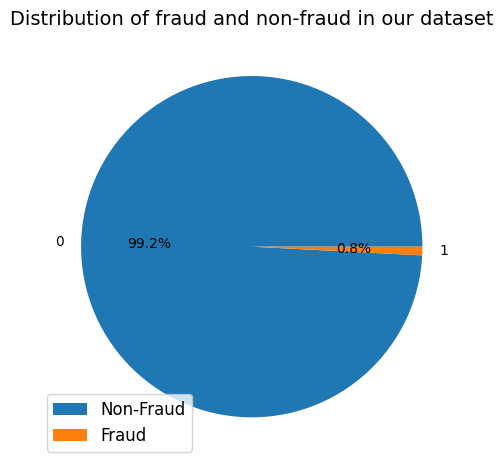

In [7]:
df = df_pre_encoded

# Create the pie chart
plt.pie(df["isFraud"].value_counts(), labels=[0,1], autopct='%1.1f%%')

# Add a title and adjust the font size
plt.title('Distribution of fraud and non-fraud in our dataset', fontsize=14)

# Add a legend and adjust the font size
plt.legend(["Non-Fraud", "Fraud"], fontsize=12)

# Add some padding to the plot
plt.tight_layout()

# Display the plot
plt.show()


## Nettoyage des données

### Drop des colonnes ayant une forte corrélations sans raison apparente

In [8]:
df.drop(["transactionId", "step", "oldbalanceDest"], axis=1, inplace=True)

### Drop des lignes dont le type est différents de "TRANSFER" ou "CASH_OUT"

Les valeurs que peuvent prendre certaines features dans nos datapoints semble optionnel à l'identification d'une fraude.

Comme on peut le constater ci-dessous, les data points qualifiés comme fraudes ont systématiquement comme valeurs pour la colonne ["type"] `TRANSFER` ou `CASH_OUT`. Toutes transactions qui n'est pas d'un de ces deux types ne peux pas être considéré comme une fraude. Nous pouvons donc retirer de notre df tout enregitrement dont la valeurs de ["type"] est différente de `TRANSFER` ou `CASH_OUT`.

In [9]:


df = df.loc[(df['type'] != 'PAYMENT') & (df['type'] != 'CASH_IN') & (df['type'] != 'DEBIT')]
df.reset_index(drop=True, inplace=True) # On reset l'index


print("Quantité de fraude / non fraude dans le df d'origine", df_original["isFraud"].value_counts(), \
      ""
      "Quantité de fraude / non fraude dans le df filtré avec transfer et cash_out : " , df["isFraud"].value_counts())

Quantité de fraude / non fraude dans le df d'origine isFraud
0    1000000
1       8213
Name: count, dtype: int64 Quantité de fraude / non fraude dans le df filtré avec transfer et cash_out :  isFraud
0    444720
1      8213
Name: count, dtype: int64


On retire donc les features cash_in, debit et payment

## Mappage des données et renommage
 

Erreur réalisé : Utilisation de LabelEncoder au lieu de la méthode get_dummies de pandas qui utilises le one hot encoding. le labelEncoder convient pour les données ordinale et le one hot encoding pour les données nominales. 

In [10]:
df.rename({"newbalanceOrig" : "newbalanceOrg"}, inplace=True, axis=1)

df = pd.concat([df,pd.get_dummies(df['type'], prefix='type_')],axis=1)
df.drop(['type'],axis=1,inplace = True)

df = df.reindex(columns=[
                        "amount",
                        "type__CASH_OUT",
                        "type__TRANSFER",
                        "oldbalanceOrg", 
                        "newbalanceOrg", 
                        "newbalanceDest", 
                        "isFraud"
                        ])



C:\Users\pault\AppData\Local\Temp\ipykernel_19800\1633194503.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename({"newbalanceOrig" : "newbalanceOrg"}, inplace=True, axis=1)


## Graphique de la nouvelle distribution des données

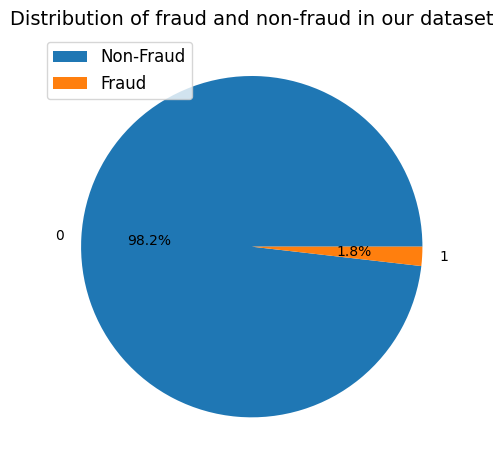

In [11]:
# Create the pie chart
plt.pie(df["isFraud"].value_counts(), labels=[0,1], autopct='%1.1f%%')

# Add a title and adjust the font size
plt.title('Distribution of fraud and non-fraud in our dataset', fontsize=14)

# Add a legend and adjust the font size
plt.legend(["Non-Fraud", "Fraud"], fontsize=12)

# Add some padding to the plot
plt.tight_layout()

# Display the plot
plt.show()

## En résumé

**Taille** : 452933 lignes par 7 colonnes

**Présence de valeur null** : Aucune valeur null

**Description de nos features** : 


| Colonne          | Description                                                                                                                |
|------------------|----------------------------------------------------------------------------------------------------------------------------|
| amount           | Le montant de chaque transaction                                                                                          |
| type__CASH_OUT              | Features crée avec one hot encoding|
| type__TRANSFER              | Features crée avec one hot encoding|
| oldbalanceOrg    | Solde de l'émetteur avant la transaction                                                                                   |
| newbalanceOrig    | Solde de l'émetteur après la transaction                                                                                   |
| newbalanceDest   | Solde du destinataire après la transaction                                                                                 |
| isFraud          | Notre cible, non fraude = 0 ; fraude = 1                                                                                   |

![image.png](src/distribution_class_dataset_filtrer_transfer_cashout.png)

In [12]:
df

,amount,type__CASH_OUT,type__TRANSFER,oldbalanceOrg,newbalanceOrg,newbalanceDest,isFraud
0,181.00,False,True,181.00,0.0,0.00,1
1,181.00,True,False,181.00,0.0,0.00,1
2,229133.94,True,False,15325.00,0.0,51513.44,0
3,215310.30,False,True,705.00,0.0,0.00,0
4,311685.89,False,True,10835.00,0.0,2719172.89,0
...,...,...,...,...,...,...,...
452928,339682.13,True,False,339682.13,0.0,339682.13,1
452929,6311409.28,False,True,6311409.28,0.0,0.00,1
452930,6311409.28,True,False,6311409.28,0.0,6379898.11,1
452931,850002.52,False,True,850002.52,0.0,0.00,1


# Entraînement des modèles

Plan :

Choix des modèles :
- Random Forest
- KNN
- ADABOOST
- Regression logistique



train_test_split

for each models :

    train with no over/undersampling 

    train using Nearmiss
    
    train using smote








## Train_test_split et features scaling
Pourquoi faire de la normalisation (features scaling) ? -> [Réponse](https://stats.stackexchange.com/questions/287425/why-do-you-need-to-scale-data-in-knn)

In [81]:
from sklearn.model_selection import train_test_split

# features
X = df.drop(["isFraud"], axis=1)

# target
y = df['isFraud']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


# Features scaling 

from sklearn.preprocessing import StandardScaler

# Création d'une fonction pour mettre à l'échelle notre df
def Standard_Scaler (df, col_names):
    features = df[col_names]
    scaler = StandardScaler().fit(features.values)
    features = scaler.transform(features.values)
    df[col_names] = features
    
    return df

X_train_noscale = X_train
X_test_noscale = X_test


col_names = ["amount", "newbalanceOrg", "newbalanceDest"]
X_train = Standard_Scaler (X_train, col_names)
X_test = Standard_Scaler (X_test, col_names)

In [14]:
df

,amount,type__CASH_OUT,type__TRANSFER,oldbalanceOrg,newbalanceOrg,newbalanceDest,isFraud
0,181.00,False,True,181.00,0.0,0.00,1
1,181.00,True,False,181.00,0.0,0.00,1
2,229133.94,True,False,15325.00,0.0,51513.44,0
3,215310.30,False,True,705.00,0.0,0.00,0
4,311685.89,False,True,10835.00,0.0,2719172.89,0
...,...,...,...,...,...,...,...
452928,339682.13,True,False,339682.13,0.0,339682.13,1
452929,6311409.28,False,True,6311409.28,0.0,0.00,1
452930,6311409.28,True,False,6311409.28,0.0,6379898.11,1
452931,850002.52,False,True,850002.52,0.0,0.00,1


## Imports des bibliothèques nécessaire pour réaliser les rapports

In [15]:
from sklearn.metrics import classification_report, auc, roc_curve

### Template évaluation métrique

```python
#Evaluating model
CM_LR = confusion_matrix(y_test,y_pred)
CR_LR = classification_report(y_test,y_pred)
fprLR, recallLR, thresholdsLR = roc_curve(y_test, y_pred)
AUC_LR = auc(fprLR, recallLR)

resultsLR = {"Confusion Matrix":CM_LR,"Classification Report":CR_LR,"Area Under Curve":AUC_LR}

#showing results from Random Forest

for measure in resultsLR:
    print(measure   ,": \n",resultsLR[measure])
    
#Create a heatmap using Seaborn
sns.heatmap(CM_LR, annot=True, fmt="d", cmap="Blues")

#Add labels, title, and axis ticks
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

#Display the plot
plt.show()
```

## Regression logistique


### Sans over/under sampling

In [82]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier


lr = LogisticRegression(max_iter=1000000, random_state=42, n_jobs=-1)
knn_clf = KNeighborsClassifier(n_jobs=-1)
rf = RandomForestClassifier()

lr.fit(X_train, y_train)
knn_clf.fit(X_train, y_train)
rf.fit(X_train_noscale, y_train)

RandomForestClassifier()

In [84]:
# Prédictions des modèles
y_pred_LR = lr.predict(X_test)
y_pred_KNN = knn_clf.predict(X_test)
y_pred_RF = rf.predict(X_test_noscale)

# LOGISTIC REGRESSION
cm_LR = confusion_matrix(y_test,y_pred_LR)
cr_LR = classification_report(y_test,y_pred_LR, output_dict=True)
fprLR, recallLR, thresholdsLR = roc_curve(y_test, y_pred_LR)
auc_LR = auc(fprLR, recallLR)

# KNN
cm_KNN = confusion_matrix(y_test,y_pred_KNN)
cr_KNN = classification_report(y_test,y_pred_KNN, output_dict=True)
fprKNN, recallKNN, thresholdsLR = roc_curve(y_test, y_pred_KNN)
auc_KNN = auc(fprLR, recallLR)

# RF
cm_RF = confusion_matrix(y_test,y_pred_RF)
cr_RF = classification_report(y_test,y_pred_RF, output_dict=True)
fprRF, recallRF, thresholdsLR = roc_curve(y_test, y_pred_RF)
auc_RF = auc(fprRF, recallRF)

# resultsLR = {"Confusion Matrix":CM_LR,"Classification Report":CR_LR,"Area Under Curve":AUC_LR}

report_df_LR = pd.DataFrame(cr_LR).transpose()
report_df_KNN = pd.DataFrame(cr_KNN).transpose()
report_df_RF = pd.DataFrame(cr_RF).transpose()

### Rapport de classification du régression logistique

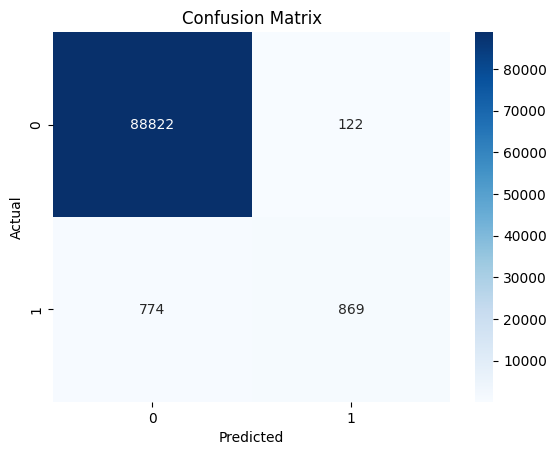

AUC : 0.763769439970955


,precision,recall,f1-score,support
0,0.991361,0.998628,0.994982,88944.000000
1,0.876892,0.528911,0.659833,1643.000000
accuracy,0.990109,0.990109,0.990109,0.990109
macro avg,0.934127,0.763769,0.827407,90587.000000
weighted avg,0.989285,0.990109,0.988903,90587.000000


In [32]:
sns.heatmap(cm_LR, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and axis ticks
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# Display the plot
plt.show()
print("AUC :",auc_LR)
report_df_LR

### Rapport de classification du KNN

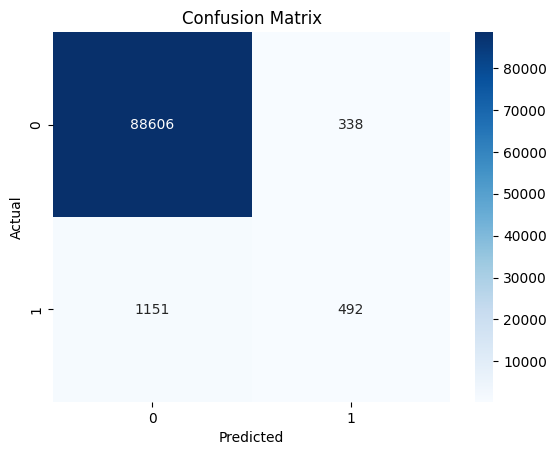

,precision,recall,f1-score,support
0,0.987176,0.996200,0.991668,88944.000000
1,0.592771,0.299452,0.397897,1643.000000
accuracy,0.983563,0.983563,0.983563,0.983563
macro avg,0.789974,0.647826,0.694782,90587.000000
weighted avg,0.980023,0.983563,0.980898,90587.000000


In [21]:
sns.heatmap(cm_KNN, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and axis ticks
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# Display the plot
plt.show()
print("AUC :",auc_KNN)
report_df_KNN

### Rapport de classification du Random Forest

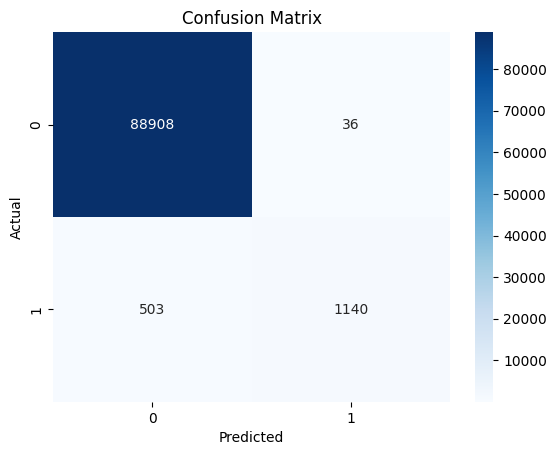

AUC : 0.8467239797022742


,precision,recall,f1-score,support
0,0.994374,0.999595,0.996978,88944.00000
1,0.969388,0.693853,0.808797,1643.00000
accuracy,0.994050,0.994050,0.994050,0.99405
macro avg,0.981881,0.846724,0.902888,90587.00000
weighted avg,0.993921,0.994050,0.993565,90587.00000


In [85]:
sns.heatmap(cm_RF, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and axis ticks
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# Display the plot
plt.show()
print("AUC :",auc_RF)
report_df_RF

#### Résultats 

La grande différence de valeur des supports de la classe 0 et la classe 1 indiquent un déséquilibre des classes. Faisons maintenant la même chose avec SMOTE.

### Avec oversampling (SMOTE)

In [24]:
from imblearn.over_sampling import SMOTE
from collections import Counter


sm = SMOTE(random_state=42, k_neighbors=5) #

X_smote_no_scale, y_smote_no_scale =  sm.fit_resample(X_train_noscale, y_train)

X_smote, y_smote = sm.fit_resample(X_train, y_train)

print('Original dataset shape:', Counter(y))
print('Resample dataset shape:', Counter(y_smote))

Original dataset shape: Counter({0: 444720, 1: 8213})
Resample dataset shape: Counter({0: 355776, 1: 355776})


In [87]:
df

,amount,type__CASH_OUT,type__TRANSFER,oldbalanceOrg,newbalanceOrg,newbalanceDest,isFraud
0,181.00,False,True,181.00,0.0,0.00,1
1,181.00,True,False,181.00,0.0,0.00,1
2,229133.94,True,False,15325.00,0.0,51513.44,0
3,215310.30,False,True,705.00,0.0,0.00,0
4,311685.89,False,True,10835.00,0.0,2719172.89,0
...,...,...,...,...,...,...,...
452928,339682.13,True,False,339682.13,0.0,339682.13,1
452929,6311409.28,False,True,6311409.28,0.0,0.00,1
452930,6311409.28,True,False,6311409.28,0.0,6379898.11,1
452931,850002.52,False,True,850002.52,0.0,0.00,1


In [86]:
lr = LogisticRegression(max_iter=1000000, random_state=42, n_jobs=-1)
knn_clf = KNeighborsClassifier(n_jobs=-1)
rf = RandomForestClassifier()

lr.fit(X_smote, y_smote)
knn_clf.fit(X_smote, y_smote)
rf.fit(X_smote_no_scale, y_smote_no_scale)

NameError: name 'X_smote_no_scale' is not defined

In [33]:
# Prédictions des modèles
y_pred_LR = lr.predict(X_test)
y_pred_KNN = knn_clf.predict(X_test)
y_pred_RF = rf.predict(X_test)

# LOGISTIC REGRESSION
cm_LR = confusion_matrix(y_test,y_pred_LR)
cr_LR = classification_report(y_test,y_pred_LR, output_dict=True)
fprLR, recallLR, thresholdsLR = roc_curve(y_test, y_pred_LR)
auc_LR = auc(fprLR, recallLR)

# KNN
cm_KNN = confusion_matrix(y_test,y_pred_KNN)
cr_KNN = classification_report(y_test,y_pred_KNN, output_dict=True)
fprKNN, recallKNN, thresholdsLR = roc_curve(y_test, y_pred_KNN)
auc_KNN = auc(fprLR, recallLR)

# RF
cm_RF = confusion_matrix(y_test,y_pred_RF)
cr_RF = classification_report(y_test,y_pred_RF, output_dict=True)
fprRF, recallRF, thresholdsLR = roc_curve(y_test, y_pred_RF)
auc_RF = auc(fprRF, recallRF)

# resultsLR = {"Confusion Matrix":CM_LR,"Classification Report":CR_LR,"Area Under Curve":AUC_LR}

report_df_LR = pd.DataFrame(cr_LR).transpose()
report_df_KNN = pd.DataFrame(cr_KNN).transpose()
report_df_RF = pd.DataFrame(cr_RF).transpose()

### Rapport de classification du régression logistique

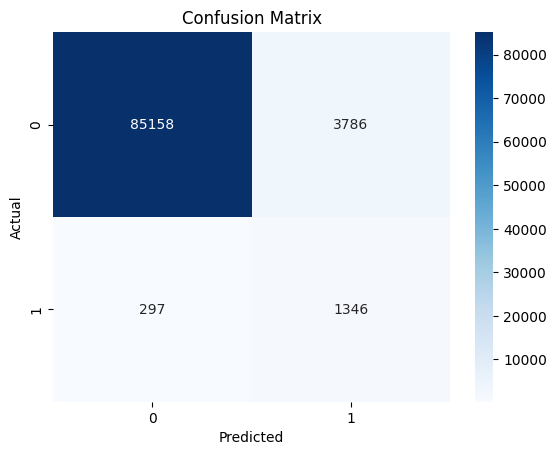

AUC : 0.8883335005759606


,precision,recall,f1-score,support
0,0.996524,0.957434,0.976588,88944.000000
1,0.262276,0.819233,0.397343,1643.000000
accuracy,0.954927,0.954927,0.954927,0.954927
macro avg,0.629400,0.888334,0.686966,90587.000000
weighted avg,0.983207,0.954927,0.966082,90587.000000


In [34]:
sns.heatmap(cm_LR, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and axis ticks
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# Display the plot
plt.show()
print("AUC :",auc_LR)
report_df_LR

### Rapport de classification du KNN

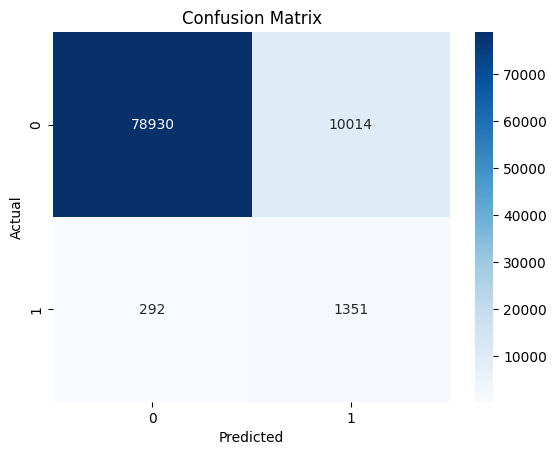

AUC : 0.8883335005759606


,precision,recall,f1-score,support
0,0.996314,0.887412,0.938715,88944.000000
1,0.118874,0.822276,0.207718,1643.000000
accuracy,0.886231,0.886231,0.886231,0.886231
macro avg,0.557594,0.854844,0.573217,90587.000000
weighted avg,0.980400,0.886231,0.925457,90587.000000


In [35]:
sns.heatmap(cm_KNN, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and axis ticks
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# Display the plot
plt.show()
print("AUC :",auc_KNN)
report_df_KNN

### Rapport de classification du Random Forest

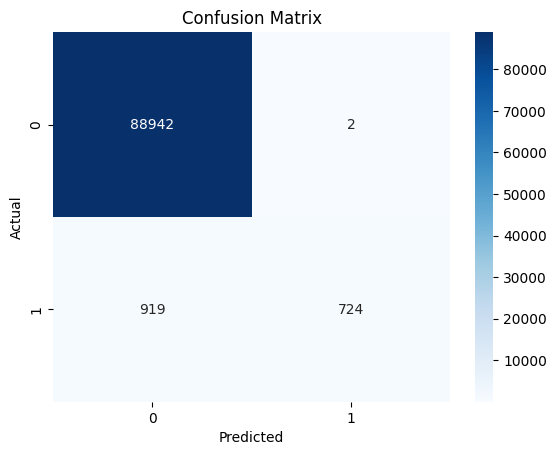

AUC : 0.7203174240431067


,precision,recall,f1-score,support
0,0.989773,0.999978,0.994849,88944.000000
1,0.997245,0.440657,0.611228,1643.000000
accuracy,0.989833,0.989833,0.989833,0.989833
macro avg,0.993509,0.720317,0.803039,90587.000000
weighted avg,0.989909,0.989833,0.987891,90587.000000


In [37]:
sns.heatmap(cm_RF, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and axis ticks
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# Display the plot
plt.show()
print("AUC :",auc_RF)
report_df_RF

### Résultats

#### Régression Logistique :

L'AUC est assez élevé à 0.8883.
La précision pour la classe minoritaire est faible, tandis que le rappel est élevé. Cela indique que le modèle identifie correctement la plupart des cas positifs, mais au prix de quelques erreurs de classification des cas négatifs en positifs.


#### KNN :

L'AUC est le même que pour la régression logistique, ce qui est assez bon.
Cependant, la précision pour la classe minoritaire est très faible, bien que le rappel soit élevé. Cela suggère que le modèle sur-prédit la classe minoritaire, ce qui peut être le résultat du sur-échantillonnage qui cause un biais du modèle envers la classe minoritaire.


#### Forêt Aléatoire (Random Forest) :

L'AUC est significativement plus bas que les autres modèles à 0.7203.
La précision est très élevée, mais le rappel est beaucoup plus bas pour la classe minoritaire par rapport aux autres modèles. Cela suggère que, bien que les prédictions du modèle pour la classe minoritaire soient assez fiables lorsqu'il prédit, il manque beaucoup de cas positifs réels.

## Recherche des meilleurs hyperparamètres pour chaque modèles

In [43]:
# Pour s'assurer que le grid search préserve le pourcentage de chaque classe lors du split dans le gridsearch
kf = StratifiedKFold(n_splits=5, shuffle=False)


lr = LogisticRegression(max_iter=1000000, random_state=42, n_jobs=-1)
knn_clf = KNeighborsClassifier(n_jobs=-1)
rf = RandomForestClassifier(random_state=42, n_jobs=-1)

### Régression logistique


In [67]:
grid_param_LR = {"penalty": ["l2"],  
                 "solver": ["sag", "newton-cholesky", "newton-cg"]}

cv_LR = grid_search = GridSearchCV(lr, param_grid=grid_param_LR, cv=kf, scoring="recall", refit=True, verbose=2, n_jobs=-1)

cv_LR.fit(X_smote, y_smote)

rf.fit(X_smote, y_smote)

Fitting 5 folds for each of 3 candidates, totalling 15 fits


RandomForestClassifier()

### KNN


In [68]:
grid_param_KNN = {"n_neighbors" : [5,15, 30, 100], 
                  "leaf_size" : [5, 25, 50],
                  "weights": ["distance", "uniform"]}

cv_KNN = GridSearchCV(knn_clf, param_grid=grid_param_KNN, cv=kf, scoring="recall", refit=True, verbose=2, n_jobs=-1)

cv_KNN.fit(X_smote, y_smote)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=KNeighborsClassifier(n_jobs=-1), n_jobs=-1,
             param_grid={'leaf_size': [5, 25, 50],
                         'n_neighbors': [5, 15, 30, 100],
                         'weights': ['distance', 'uniform']},
             scoring='recall', verbose=2)

### Random Forest

In [71]:
grid_param_RF = {"n_estimators" : [100, 300], "criterion" : ["gini","entropy"], "max_features" : ["sqrt", "log2"],"min_samples_leaf" : [4, 10]}

cv_RF = GridSearchCV(rf, param_grid=grid_param_RF, cv=kf, scoring="recall", refit=True, verbose=2, n_jobs=-1)

cv_RF.fit(X_smote, y_smote)

Fitting 5 folds for each of 18 candidates, totalling 90 fits


GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'criterion': ['gini', 'entropy', 'log_loss'],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 10]},
             scoring='recall', verbose=2)

## Prédictions des modèles


In [72]:
y_pred_LR = cv_LR.predict(X_test)
y_pred_KNN = cv_KNN.predict(X_test)
y_pred_RF = cv_RF.predict(X_test)

# LOGISTIC REGRESSION
cm_LR = confusion_matrix(y_test,y_pred_LR)
cr_LR = classification_report(y_test,y_pred_LR, output_dict=True)
fprLR, recallLR, thresholdsLR = roc_curve(y_test, y_pred_LR)
auc_LR = auc(fprLR, recallLR)

# KNN
cm_KNN = confusion_matrix(y_test,y_pred_KNN)
cr_KNN = classification_report(y_test,y_pred_KNN, output_dict=True)
fprKNN, recallKNN, thresholdsLR = roc_curve(y_test, y_pred_KNN)
auc_KNN = auc(fprLR, recallLR)

# RF
cm_RF = confusion_matrix(y_test,y_pred_RF)
cr_RF = classification_report(y_test,y_pred_RF, output_dict=True)
fprRF, recallRF, thresholdsLR = roc_curve(y_test, y_pred_RF)
auc_RF = auc(fprRF, recallRF)

# resultsLR = {"Confusion Matrix":CM_LR,"Classification Report":CR_LR,"Area Under Curve":AUC_LR}

report_df_LR = pd.DataFrame(cr_LR).transpose()
report_df_KNN = pd.DataFrame(cr_KNN).transpose()
report_df_RF = pd.DataFrame(cr_RF).transpose()

### Rapport de classification du régression logistique

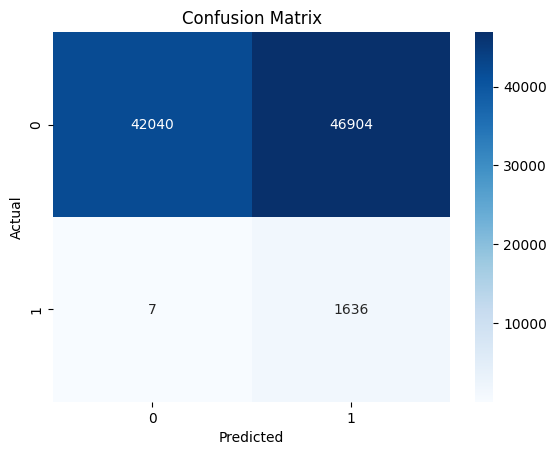

Best parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 1}
AUC : 0.7341982268011482


,precision,recall,f1-score,support
0,0.999834,0.472657,0.641876,88944.000000
1,0.033704,0.995740,0.065201,1643.000000
accuracy,0.482144,0.482144,0.482144,0.482144
macro avg,0.516769,0.734198,0.353539,90587.000000
weighted avg,0.982311,0.482144,0.631417,90587.000000


In [73]:
sns.heatmap(cm_LR, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and axis ticks
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# Display the plot
plt.show()
print('Best parameters:', cv_RF.best_params_)
print("AUC :",auc_LR)
report_df_LR

1ère obs : 
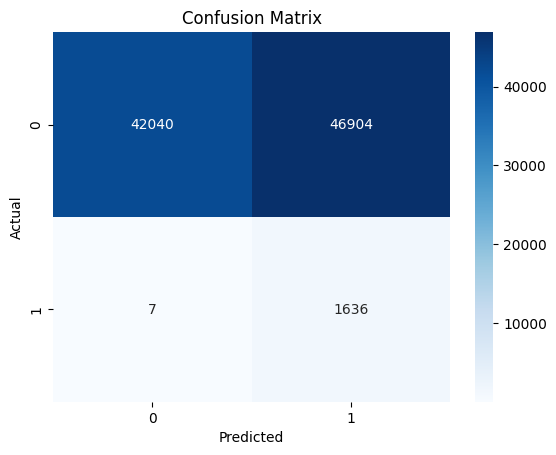

Best parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 1}
AUC : 0.7341982268011482

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>precision</th>
      <th>recall</th>
      <th>f1-score</th>
      <th>support</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>0.999834</td>
      <td>0.472657</td>
      <td>0.641876</td>
      <td>88944.000000</td>
    </tr>
    <tr>
      <th>1</th>
      <td>0.033704</td>
      <td>0.995740</td>
      <td>0.065201</td>
      <td>1643.000000</td>
    </tr>
    <tr>
      <th>accuracy</th>
      <td>0.482144</td>
      <td>0.482144</td>
      <td>0.482144</td>
      <td>0.482144</td>
    </tr>
    <tr>
      <th>macro avg</th>
      <td>0.516769</td>
      <td>0.734198</td>
      <td>0.353539</td>
      <td>90587.000000</td>
    </tr>
    <tr>
      <th>weighted avg</th>
      <td>0.982311</td>
      <td>0.482144</td>
      <td>0.631417</td>
      <td>90587.000000</td>
    </tr>
  </tbody>
</table>
</div>

### Rapport de classification du KNN

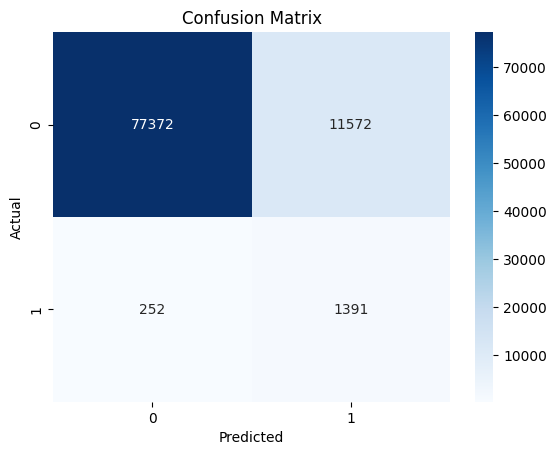

Best parameters: {'leaf_size': 5, 'n_neighbors': 100, 'weights': 'distance'}
AUC : 0.7341982268011482


,precision,recall,f1-score,support
0,0.996754,0.869896,0.929014,88944.000000
1,0.107305,0.846622,0.190470,1643.000000
accuracy,0.869474,0.869474,0.869474,0.869474
macro avg,0.552029,0.858259,0.559742,90587.000000
weighted avg,0.980621,0.869474,0.915619,90587.000000


In [74]:
sns.heatmap(cm_KNN, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and axis ticks
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# Display the plot
plt.show()
print('Best parameters:', cv_KNN.best_params_)
print("AUC :",auc_KNN)
report_df_KNN

### Rapport de classification du Random Forest

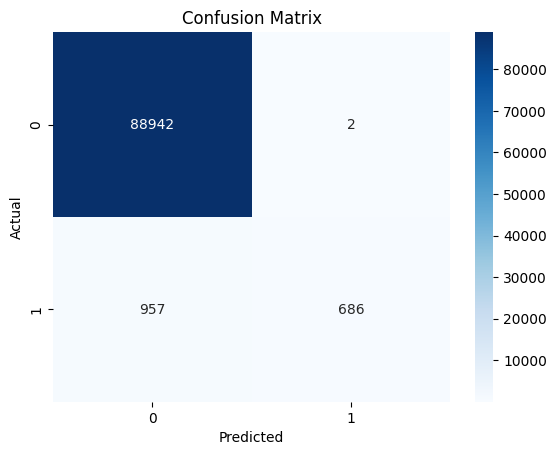

Best parameters: {'criterion': 'log_loss', 'max_features': 'sqrt', 'min_samples_leaf': 1}
AUC : 0.7087532122354377


,precision,recall,f1-score,support
0,0.989355,0.999978,0.994638,88944.000000
1,0.997093,0.417529,0.588589,1643.000000
accuracy,0.989413,0.989413,0.989413,0.989413
macro avg,0.993224,0.708753,0.791613,90587.000000
weighted avg,0.989495,0.989413,0.987273,90587.000000


In [83]:
sns.heatmap(cm_RF, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and axis ticks
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# Display the plot
plt.show()
print('Best parameters:', cv_RF.best_params_)
print("AUC :",auc_RF)
report_df_RF

# template evaluation

In [ ]:
y_pred = logistic_regression_model.predict(X_test)
  
# Evaluating model
CM_LR = confusion_matrix(y_test,y_pred)
CR_LR = classification_report(y_test,y_pred)
fprLR, recallLR, thresholdsLR = roc_curve(y_test, y_pred)
AUC_LR = auc(fprLR, recallLR)

resultsLR = {"Confusion Matrix":CM_LR,"Classification Report":CR_LR,"Area Under Curve":AUC_LR}

# showing results from Random Forest

for measure in resultsLR:
    print(measure   ,": \n",resultsLR[measure])

In [ ]:
print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

In [ ]:
y_pred_no_sampling = grid_search.predict(X_test)
cm_no_sampling = confusion_matrix(y_test, y_pred_no_sampling)
cm_no_sampling

In [ ]:
# Create a heatmap using Seaborn
sns.heatmap(cm_no_sampling, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and axis ticks
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# Display the plot
plt.show()

In [ ]:
import pickle
filename = 'src/modeleregressionlog-penaltyl2-solversaga-tol0d001-recall0d78.pkl'
with open(filename, 'wb') as file:
    pickle.dump(grid_search, file)

"tol" : [1e-2] # Decreasing tolerance from 1e-4 by default to 1e-2 - 2.3m

    Best parameters: {'max_iter': 100000, 'penalty': 'l2', 'solver': 'saga', 'tol': 0.01}
    Best score: 0.4888637711057783


    Best parameters: {'max_iter': 100000, 'penalty': 'l2', 'solver': 'saga', 'tol': 0.001}
    Best score: 0.7860704381021766

    Matrice :
    [[88541][403]]
    [[433 ][1210]]

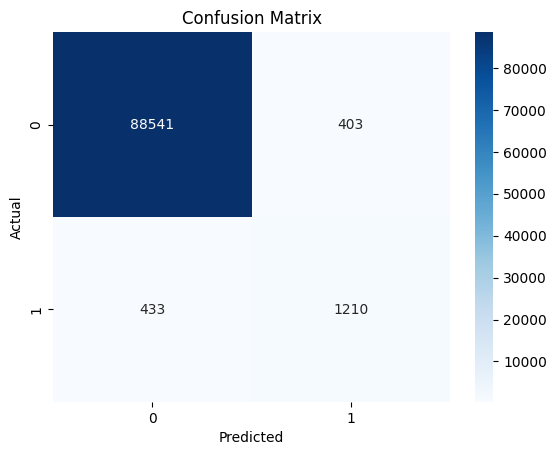




## ADABOOST

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

param_grid = {
    'n_estimators': [200],
    'learning_rate': [1.0, 1.5, 2.0]
}

# Initialiser GridSearchCV pour SMOTE avec F1-score comme métrique de scoring
grid_search_smote = GridSearchCV(estimator=AdaBoostClassifier(algorithm="SAMME", random_state = 42), param_grid=param_grid, cv=kf, scoring='recall', n_jobs=-1, verbose=True)

grid_search_smote.fit(X_smote, y_smote)


In [ ]:
print("Meilleurs hyperparamètres trouvés pour SMOTE : ", grid_search_smote.best_params_)
y_pred_no_sampling = grid_search_smote.predict(X_test)
  
# Evaluating model
CM_RF = confusion_matrix(y_test,y_pred_no_sampling)
CR_RF = classification_report(y_test,y_pred_no_sampling)
fprRF, recallRF, thresholdsRF = roc_curve(y_test, y_pred_no_sampling)
AUC_RF = auc(fprRF, recallRF)

resultsRF = {"Confusion Matrix":CM_RF,"Classification Report":CR_RF,"Area Under Curve":AUC_RF}

# showing results from Random Forest

for measure in resultsRF:
    print(measure   ,": \n",resultsRF[measure])

Meilleurs hyperparamètres trouvés pour SMOTE :  {'learning_rate': 1.0, 'n_estimators': 100}
Confusion Matrix : 
 [[88386   558]
 [ 1253   390]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     88944
           1       0.41      0.24      0.30      1643

    accuracy                           0.98     90587
   macro avg       0.70      0.62      0.65     90587
weighted avg       0.98      0.98      0.98     90587

Area Under Curve : 
 0.6155485265294981


## KNN

### Sans over/under sampling
#### Features scaling



In [ ]:
from sklearn.neighbors import KNeighborsClassifier

grid_parameters_no_sampling = {"weights" : ["distance"], "algorithm" : ["ball_tree", "kd_tree"], "leaf_size" : [3, 5, 15, 50]}  

knn_clf = KNeighborsClassifier()

knn_no_sampling = GridSearchCV(knn_clf, grid_parameters_no_sampling, scoring="f1", cv=kf, n_jobs=-1, verbose=2)

knn_no_sampling.fit(X_train, y_train)

In [ ]:
y_pred = knn_no_sampling.predict(X_test)
  
# Evaluating model
CM_LR = confusion_matrix(y_test,y_pred)
CR_LR = classification_report(y_test,y_pred)
fprLR, recallLR, thresholdsLR = roc_curve(y_test, y_pred)
AUC_LR = auc(fprLR, recallLR)

resultsLR = {"Confusion Matrix":CM_LR,"Classification Report":CR_LR,"Area Under Curve":AUC_LR}


print('Best parameters:', knn_no_sampling.best_params_)

for measure in resultsLR:
    print(measure   ,": \n",resultsLR[measure])
    
# Create a heatmap using Seaborn
sns.heatmap(CM_LR, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and axis ticks
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# Display the plot
plt.show()

DEFAULT : 

Confusion Matrix : 
 [[88606   338]
 [ 1151   492]]
Classification Report : 

               precision    recall  f1-score   support

           0       0.99      1.00      0.99     88944
           1       0.59      0.30      0.40      1643

    accuracy                           0.98     90587
   macro avg       0.79      0.65      0.69     90587
weighted avg       0.98      0.98      0.98     90587

Area Under Curve : 
 0.6478260388175886

#### 2ème mesure
Best parameters: {'weights': 'distance'}
Confusion Matrix : 
 [[88292   652]
 [  709   934]]
Classification Report : 

               precision    recall  f1-score   support

           0       0.99      0.99      0.99     88944
           1       0.59      0.57      0.58      1643

    accuracy                           0.98     90587
   macro avg       0.79      0.78      0.79     90587
weighted avg       0.98      0.98      0.98     90587

Area Under Curve : 
 0.7805709258190536


#### 3ème mesure

Best parameters: {'algorithm': 'ball_tree', 'leaf_size': 15, 'weights': 'distance'}
Confusion Matrix : 
 [[88292   652]
 [  709   934]]
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      0.99      0.99     88944
           1       0.59      0.57      0.58      1643

    accuracy                           0.98     90587
   macro avg       0.79      0.78      0.79     90587
weighted avg       0.98      0.98      0.98     90587

Area Under Curve : 
 0.7805709258190536


### Avec undersampling (Nearmiss)

In [ ]:
from imblearn.under_sampling import NearMiss
from collections import Counter

nm = NearMiss()

X_near_miss, y_near_miss = nm.fit_resample(X_train, y_train)

print('Original dataset shape:', Counter(y))
print('Resample dataset shape:', Counter(y_near_miss))

In [ ]:
kf = StratifiedKFold(n_splits=5, shuffle=False)

logistic_regression_model_nearmiss = LogisticRegression(random_state=42)
param_logistic_regression = {
    "max_iter" : [100000],
    "penalty" : ["l2", None],
    "class_weight" : ["balanced", None],
    "solver" : ["saga"]

}

grid_search = GridSearchCV(logistic_regression_model, param_grid=param_logistic_regression, cv=kf, scoring='recall', verbose=2, n_jobs=-1)
grid_search.fit(X_near_miss, y_near_miss)

### Avec oversampling (SMOTE)

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

In [ ]:


from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, auc, roc_curve
kf = StratifiedKFold(n_splits=5, shuffle=False)

grid_parameters_with_over_sampling = {"n_neighbors" : [5,15], 
                                      "leaf_size" : [5, 25],
                                      "weights": ["distance", "uniform"]
                                      }

knn_over_sampling = KNeighborsClassifier(n_jobs=-1)

grid_search = GridSearchCV(knn_over_sampling, param_grid=grid_parameters_with_over_sampling, cv=kf, scoring="recall", refit=True, verbose=2, n_jobs=-1)

# grid_search = RandomizedSearchCV(knn_over_sampling, param_distributions=grid_parameters_with_over_sampling,cv=kf, n_iter = 10, scoring="recall", refit=True, verbose=2, n_jobs=-1)

grid_search.fit(X_smote, y_smote) 
  

y_pred_no_sampling = grid_search.predict(X_test)
  
# Evaluating model
CM_RF = confusion_matrix(y_test,y_pred_no_sampling)
CR_RF = classification_report(y_test,y_pred_no_sampling)
fprRF, recallRF, thresholdsRF = roc_curve(y_test, y_pred_no_sampling)
AUC_RF = auc(fprRF, recallRF)

resultsRF = {"Confusion Matrix":CM_RF,"Classification Report":CR_RF,"Area Under Curve":AUC_RF}

# showing results from Random Forest

for measure in resultsRF:
    print(measure   ,": \n",resultsRF[measure])

In [ ]:
print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

Version : V1
Temps passé : 41s
Fitting 5 folds for each of 2 candidates, totalling 10 fits
Confusion Matrix : 
 [[77890 11054]
 [  273  1370]]
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      0.88      0.93     88944
           1       0.11      0.83      0.19      1643

    accuracy                           0.87     90587
   macro avg       0.55      0.85      0.56     90587
weighted avg       0.98      0.87      0.92     90587

Area Under Curve : 
 0.854780044741098




In [ ]:
with open('src/KNN_SMOTE_V1.pkl', 'wb') as file:
    pickle.dump(grid_search, file)

In [ ]:
'''
KNN SMOTE V1 : 35 minutes
grid_parameters_with_over_sampling = {"n_neighbors" : [3, 5, 7], 
                                      "weights" : ["unifmorm","distance"], 
                                      "algorithm" : ["ball_tree", "kd_tree", "brute"], 
                                      "leaf_size" : [15,30,50,]}
               
               KNN SMOTE V2                       
grid_parameters_with_over_sampling = {"n_neighbors" : [7, 15, 20], 
                                      "algorithm" : ["ball_tree"], 
                                      "leaf_size" : [3,7,15]}                                      
                                      
Best parameters: {'algorithm': 'ball_tree', 'leaf_size': 15, 'n_neighbors': 7, 'weights': 'distance'}
Best score: 0.918201346312936


KNN SMOTE V3
Best parameters: {'leaf_size': 10, 'n_neighbors': 7}
Best score: 0.9182997203309137
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Confusion Matrix : 
 [[78603 10341]
 [  281  1362]]
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      0.88      0.94     88944
           1       0.12      0.83      0.20      1643

    accuracy                           0.88     90587
   macro avg       0.56      0.86      0.57     90587
weighted avg       0.98      0.88      0.92     90587

Area Under Curve : 
 0.8563536137874493



'''

print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

1er essai : grid_parameters_with_over_sampling = {"n_neighbors" : [3, 5, 7], "leaf_size" : [20]} 2.54m 
    Best parameters: {'leaf_size': 20, 'n_neighbors': 5}
    Best score: 0.8954651302345649

In [ ]:


cm_over_sampling = confusion_matrix(y_test, y_pred_no_sampling)

# Create a heatmap using Seaborn
sns.heatmap(cm_over_sampling, annot=True, fmt="d", cmap="Blues")

# Add labels, title, and axis ticks
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")

# Display the plot
plt.show()

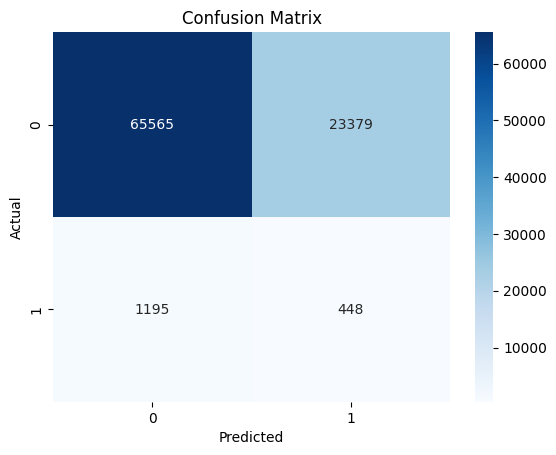

# Random forest

from sklearn.ensemble import RandomForestClassifier